In [1]:
import pandas as pd
import pickle 
import xml.etree.cElementTree as ET
from bs4 import BeautifulSoup
import requests
import urllib
import os
import zipfile
import lxml
import h5py

%load_ext autoreload
%autoreload 2
#import patent_utils as pu

In [9]:
%ls

APPLICATION_XML_FILE_INSPECTION.ipynb  data/
COMBINING_ALL_DATA.ipynb               data-checking.ipynb
GRANTS_XML_PREPARATION.ipynb           data_collection.ipynb
__pycache__/                           patent_utils.py
check-citations-data.ipynb


# 1. Load Office Actions/Application/Grants


In [11]:
%%time
grants = pd.read_csv('/work/data/grants/2012_all_grants.csv').iloc[:, 1:]
apps = pd.read_csv('/work/data/apps/2017_all_apps.csv').iloc[:, 1:]
oas = pd.read_csv('/work/data/office_actions.csv')
cits = pd.read_csv('/work/data/citations.csv')
rej = pd.read_csv('/work/data/rejections.csv')

grants['pub_doc-number'].loc[grants['pub_doc-number'].str.startswith('0')] = \
grants['pub_doc-number'].loc[grants['pub_doc-number'].str.startswith('0')].\
    astype(int).astype(str)
grants = grants.rename(columns = {'pub_doc-number': 'parsed'})
apps = apps.rename(columns = {'app_doc-number': 'app_id'})


<string>:2: DtypeWarning: Columns (1,4,5) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 1min 35s, sys: 17.9 s, total: 1min 52s
Wall time: 2min 17s


/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [11]:
xa = apps.loc[:, ['app_id', 'fnm']].rename(columns = {'fnm':'app_fnm'}).\
         merge(cits, on='app_id', how='inner').\
         merge(grants, on='parsed', how='inner')
xa.loc[~xa.ifw_number.isnull()].\
   merge(oas, on=['app_id', 'ifw_number'], how='inner').app_id.unique().shape

(471,)

# 2. Get a sense about data coverage/size
- 2 Mn unique app_ids with citations
- 5 Mn citations in total
- 1.9 Mn citations with office actions in total

In [38]:
oas_cits = oas.merge(cits, on=['app_id', 'ifw_number'], how='inner')

In [10]:
oas.head().T

NameError: name 'oas' is not defined

In [12]:
apps = [pd.read_csv('/work/data/apps/'+x).iloc[:, 1:] for x in 
            os.listdir('/work/data/apps') if '.csv' in x]
apps = pd.concat(apps)

grants = [pd.read_csv('/work/data/grants/'+x).iloc[:, 1:] for x in 
             os.listdir('/work/data/grants') if '.csv' in x]
grants = pd.concat(grants)

grants['pub_doc-number'].loc[grants['pub_doc-number'].str.startswith('0')] = \
grants['pub_doc-number'].loc[grants['pub_doc-number'].str.startswith('0')].\
    astype(int).astype(str)
grants = grants.rename(columns = {'pub_doc-number': 'parsed'})
apps = apps.rename(columns = {'app_doc-number': 'app_id'})


/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [42]:
xa = apps.loc[:, ['app_id', 'fnm']].rename(columns = {'fnm':'app_fnm'}).\
          merge(cits, on='app_id', how='inner').\
          merge(grants, on='parsed', how='inner')
xa_fin = xa.loc[~xa.ifw_number.isnull()].
            merge(oas, on=['app_id', 'ifw_number'], how='inner')

KeyboardInterrupt: 

In [7]:
xa_fin.to_csv('../data/applications_with_office_actions_citing_grants_with_inner_join.csv')

NameError: name 'xa_fin' is not defined

In [2]:
xa_fin = pd.read_csv('../data/applications_with_office_actions_citing_grants_with_inner_join.csv').iloc[:, 1:]

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
xa_fin['app_year'] = xa_fin.app_fnm.apply(lambda x: x.split('/')[4])
xa_fin['grant_year'] = xa_fin.fnm.apply(lambda x: x.split('/')[4])

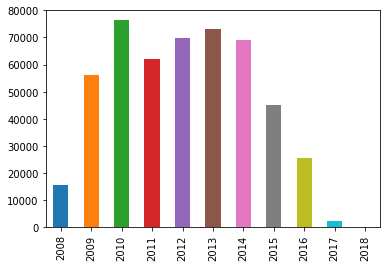

In [9]:
%matplotlib inline
xa_fin.loc[:, ['app_id', 'app_year']].drop_duplicates().app_year.value_counts().sort_index().plot.bar()

Looking at the distribution of applications per year, we find a trend for lower # of applications. While this is somewhat odd, it correponds with what we see in the "Unlocking Office Action Traits.pdf" file

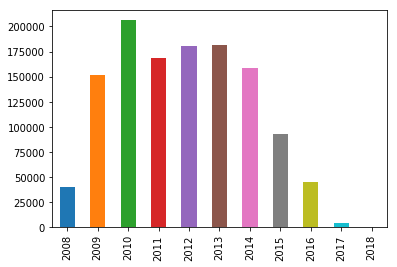

In [4]:
%matplotlib inline
xa_fin.app_year.value_counts().sort_index().plot.bar()

In [28]:
xa_fin.loc[xa_fin['fnm'].str.contains('/2012/') & xa_fin['app_fnm'].str.contains('/2017/')].shape

(645, 41)

In [ ]:
app_fnms = xa_fin.loc[:, ['app_id', 'app_fnm']].drop_duplicates()
app_fnms = app_fnms.groupby('app_id')['app_fnm'].last().to_frame('app_fnm')
app_fnms['directory'] = app_fnms.app_fnm.apply(
    lambda x: '/'.join(x.split('/')[:-1]))
app_fnms = app_fnms.sort_values('app_fnm')

In [ ]:
h5file = h5py.File('/work/data/applications.h5', 'w')
for x in app_fnms.iterrows():
    if os.path.exists(newdir):
        os.mkdir(newdir)
    f = open(x[1]['app_fnm'], 'r')
    fStr = f.read()
    f.close()
    h5file.create_dataset(str(x[0]), data = fStr)
h5file.close()

In [18]:
grants_fnms = xa_fin.loc[:, ['parsed', 'fnm']].drop_duplicates()
grants_fnms = grants_fnms.groupby('parsed')['fnm'].last().to_frame('fnm')
grants_fnms['directory'] = grants_fnms.fnm.apply(
    lambda x: '/'.join(x.split('/')[:-1]))
grants_fnms = grants_fnms.sort_values('fnm')

In [ ]:
h5file = h5py.File('/work/data/grants_n6.h5', 'w')
for x in tqdm(grants_fnms.iterrows()):
    #if os.path.exists(newdir):
    #    os.mkdir(newdir)
    f = open(x[1]['fnm'], 'r', encoding='utf-8')
    fStr = f.read()
    f.close()
    #from IPython.core.debugger import Tracer; Tracer()()
    h5file.create_dataset(str(x[0]), data = fStr)
h5file.close()

81904it [05:58, 228.24it/s]

In [ ]:
print(apps.app_id.shape[0] - apps.app_id.unique().shape[0])
apps = apps.loc[apps.reset_index().groupby('app_id')['app_date'].idxmax()]
print(apps.app_id.shape[0] - apps.app_id.unique().shape[0])
apps = pd.concat([apps.set_index('app_id')], axis=1, keys=['APPLICATION'])

In [ ]:
cits = pd.concat([cits.set_index(['app_id', 'ifw_number', 'parsed'])],
                  axis=1, keys=['CITATIONS'])

# Brief summary
- 2017 Applications have 300K citations
- 2017 Applications have around 30K of office actions

# Test download files

In [2]:
!gsutil cp gs://ppr/fast_data/statistical_learning/ml-study-phys/patent/patent_grants_with_office_actions_2005-2012.zip .

/bin/sh: 1: gsutil: not found


In [35]:
import h5py
filename = '../data/grants_n6.h5'
f = h5py.File(filename, 'r')
#print("Keys: %s" % f.keys())
a_group_key = list(f.keys())

In [36]:
len(a_group_key)

398999